# **Comparing DBSCAN and HDBSCAN**

# DBSCAN & HDBSCAN (Density-Based Clustering)

DBSCAN (Density-Based Spatial Clustering of Applications with Noise) and HDBSCAN (Hierarchical Density Based Spatial Clustering of Applications with Noise) are both density based clustering algorithms that group together points that are closely packed while marking outliers as noise.

## 1. DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
DBSCAN is an unsupervised clustering algorithm that groups together points that are closely packed and marks points that lie in low-density regions as outliers (noise).

### How DBSCAN works?
1. Define two parameters:
   * `eps` (epsilon): The maximum distance within which points are considered neighbors.
   * `min_samples`: The min no of points required to form a dense region (cluster).
2. Identify core points
   * A point is a core point if atleast `min_samples` points (including itself) are within `eps` distance.
3. Expand Clusters
   * Start with a core point and recursively and all directly and indirectly connected points.
4. Mark Noise
   * Points that are not part of any cluster are classified as noise (outliers).
  
**Advantages of DBSCAN**
1. Can detect arbitrarily shaped clusters
2. No need to specify the number of clusters (like K-Means)
3. Handles outliers well
4. Works with non-linearly separable data

**Disadvantages of DBSCAN**
1.  Performance drops in high-dimensional data
2.  Struggles with clusters of varying density
3.  Sensitive to eps value


## 2. HDBSCAN (Hierarchical DBSCAN)
HDBSCAN is an improved version of DBSCAN that automatically detects clusters of varying densities and builds a hierarchical structure for better cluster formation.

### How HDBSCAN Works
1. Uses DBSCAN principles but removes the need to manually set eps.
2. Constructs a hierarchy of clusters by varying `min_samples` dynamically.
3. Selects stable clusters by cutting the hierarchical tree at the most meaningful level.
4. Assigns outliers dynamically instead of relying on a fixed `eps` threshold.

**Advantages of HDBSCAN**
1. No need to manually set `eps`
2. Handles clusters of varying densities
3. Better at detecting noise
4. More flexible and accurate than DBSCAN

**Disadvantages of HDBSCAN**
1. More computationally expensive than DBSCAN
2. Requires more parameter tuning (e.g., min_cluster_size)

### Objectives

1. Use Scikit-learn to implement DBSCAN and HDBSCAN clustering models to real data.
2. Compare the performance of the two models.

## Introduction

In this project we will create the two clustering models using the data curated by StatCan containing the names, types, and locations of cultural and art facilities across Canada, We'll focus on the museum locations provided across Canada.

**Data source: The open Database of Cultural and Art Facilities (ODCAF)**

A collection of open data containing the names, types and location of cultural and art facilities across Canada. it is released under the Open Government License - Canada. The different types of facilities are labeled under 'ODCAF_Facility_Type'.

##### Landing page:
https://www.statcan.gc.ca/en/lode/databases/odcaf

##### link to zip file:
https://www150.statcan.gc.ca/n1/en/pub/21-26-0001/2020001/ODCAF_V1.0.zip?st=brOCT3Ry

In [2]:
!pip install hdbscan
!pip install geopandas
!pip install contextily
!pip install shapely

#import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.preprocessing import StandardScaler

#geographical tools
import geopandas as gpd # pandas dataframe - like geodata frames for geographical data
import contextily as ctx # used for obtaining a base map of canada
from shapely.geometry import Point

import warnings
warnings.filterwarnings('ignore')

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### Download the canada map for reference

In [3]:
import requests
import zipfile
import io
import os

#url of the zip file on the cloud server
zip_file_url = 'https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/YcUk-ytgrPkmvZAh5bf7zA/Canada.zip'

#directory to save the extracted TIFF file
output_dir = './'
os.makedirs(output_dir, exist_ok = True)

#step 1 download the zip file
response = requests.get(zip_file_url)
response.raise_for_status()  # Ensure the request was successful
# Step 2: Open the ZIP file in memory
with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
    # Step 3: Iterate over the files in the ZIP
    for file_name in zip_ref.namelist():
        if file_name.endswith('.tif'):  # Check if it's a TIFF file
            # Step 4: Extract the TIFF file
            zip_ref.extract(file_name, output_dir)
            print(f"Downloaded and extracted: {file_name}")

Downloaded and extracted: Canada.tif


#### Include a plotting function

The code for a helper function is provided to help us plot our results. Although we don't need to worry about the details, it's quite instructive as it uses a geopandas dataframe and a basemap to plot coloured cluster points on a map of Canada.

### Explore the data and extract what we need from it

Let's start by loading the data set into pandas dataframe and displaying the first few rows.

In [37]:
url = ('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/r-maSj5Yegvw2sJraT15FA/ODCAF-v1-0.csv')
df = pd.read_csv(url, encoding='ISO-8859-1')
df.head()

,Index,Facility_Name,Source_Facility_Type,ODCAF_Facility_Type,Provider,Unit,Street_No,Street_Name,Postal_Code,City,Prov_Terr,Source_Format_Address,CSD_Name,CSDUID,PRUID,Latitude,Longitude
0,1,#Hashtag Gallery,..,gallery,toronto,..,801,dundas st w,M6J 1V2,toronto,on,801 dundas st w,Toronto,3520005,35,43.65169472,-79.40803272
1,2,'Ksan Historical Village & Museum,historic site-building or park,museum,canadian museums association,..,1500,62 hwy,V0J 1Y0,hazelton,bc,1500 hwy 62 hazelton british columbia v0j 1y0 ...,Hazelton,5949022,59,55.2645508,-127.6428124
2,3,'School Days' Museum,community/regional museum,museum,canadian museums association,..,427,queen st,E3B 5R6,fredericton,nb,427 queen st fredericton new brunswick e3b 5r6...,Fredericton,1310032,13,45.963283,-66.6419017
3,4,10 Austin Street,built heritage properties,heritage or historic site,moncton,..,10,austin st,E1C 1Z6,moncton,nb,10 austin st,Moncton,1307022,13,46.09247776,-64.78022946
4,5,10 Gates Dancing Inc.,arts,miscellaneous,ottawa,..,..,..,..,ottawa,on,..,Ottawa,3506008,35,45.40856224,-75.71536766


In [39]:
#facility type and there count
df.ODCAF_Facility_Type.value_counts()

ODCAF_Facility_Type
library or archives                     3013
museum                                  1938
gallery                                  810
heritage or historic site                620
theatre/performance and concert hall     583
festival site                            346
miscellaneous                            343
art or cultural centre                   225
artist                                    94
Name: count, dtype: int64

In [40]:
df = df[['Latitude', 'Longitude']]
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7972 entries, 0 to 7971
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Latitude   7972 non-null   object
 1   Longitude  7972 non-null   object
dtypes: object(2)
memory usage: 124.7+ KB


In [43]:
# Remove unwanted characters like trailing commas and extra spaces
df['Latitude'] = df['Latitude'].astype(str).str.replace(',', '').str.strip()
df['Longitude'] = df['Longitude'].astype(str).str.replace(',', '').str.strip()

# Convert to float, coercing errors to NaN
df[['Latitude', 'Longitude']] = df[['Latitude', 'Longitude']].apply(pd.to_numeric, errors='coerce')

# Drop any remaining rows with NaN values after conversion
df = df.dropna(subset=['Latitude', 'Longitude'])


### Build a DBSCAN model

Correctly sacle thye coordinates for DBSCAN (since DBSCAN is sensitive to scale)

In [44]:
#In this case we now how to scale the coordinates. Using standardization would be an error because we aren't using the full range of lat/lng coordinates.
# Since l;atitude has a range of +/- 90 degrees and longitude ranges from 0 to 360 degrees, the correct scaling is to double the longitude coordinates (or half the latitudes)
coords_scaled = df.copy()
coords_scaled['Latitude'] = 2*coords_scaled['Latitude']

### Apply DBSCAN with bEuclidean distance to the scaled coordinates

In [47]:
min_samples = 3 #min no of samples needed to form a neighbourhood
eps = 1.0 # neighbourhood search radius
metric = 'euclidean' # distance measure

dbscan = DBSCAN(eps = eps, min_samples = min_samples, metric = metric).fit(coords_scaled)

#### Add cluster label to the dataframe

In [48]:
df['Cluster'] = dbscan.fit_predict(coords_scaled)  #assign the cluster labels

#Display the size of each cluster
df['Cluster'].value_counts()

Cluster
 0     4643
 2      829
 10     515
 3      270
 7      171
-1       84
 14      25
 26      21
 6       20
 11      14
 17      12
 24      10
 22      10
 4        8
 31       7
 35       7
 12       7
 15       6
 34       6
 27       5
 32       5
 18       5
 1        5
 20       4
 33       4
 19       4
 38       4
 25       4
 16       4
 21       4
 9        4
 8        4
 37       3
 36       3
 5        3
 29       3
 30       3
 28       3
 13       3
 23       3
 39       3
Name: count, dtype: int64

Our DBSCAN output shows several clusters, with Cluster 0 (4643 points) and Cluster 2 (829 points) being the largest, while many smaller clusters exist (as small as 3-7 points). You also have 84 noise points (-1 label).

This means:

1. DBSCAN has successfully identified dense regions, forming large clusters (0 and 2).

2. Many small clusters (with 3-10 points) indicate that some data points are sparsely connected.

3. Noise points (-1) are relatively low (only 84), which means most points are being assigned to clusters.

#### Plot the museum on a basemap of Canada, colored by cluster label.

In [50]:
help(plot_clustered_locations)


Help on function plot_clustered_locations in module __main__:

plot_clustered_locations(df)



In [51]:
print(plot_clustered_locations.__code__.co_varnames)


('df', 'gdf', 'fig', 'ax', 'non_noise', 'noise')


In [52]:
def plot_clustered_locations(df, title="Clustered Locations"):
    import matplotlib.pyplot as plt
    
    plt.figure(figsize=(10, 6))
    plt.scatter(df["Longitude"], df["Latitude"], c=df["Cluster"], cmap="tab20", s=10)
    plt.colorbar(label="Cluster Label")
    plt.title(title)  # Add title support
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.show()


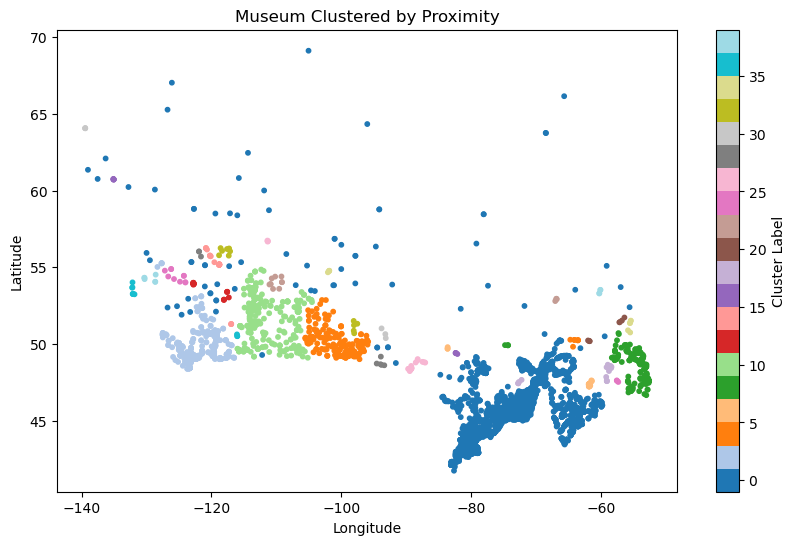

In [53]:
plot_clustered_locations(df, title="Museum Clustered by Proximity")


* What do we see?
* What size is the smallest cluster?
* Do we think the clusters make sense in terms of what we expect to see?
* Do you think there should be more clusters in some regions? why?

One key thing to notice here is that the clusters are not uniformly dense.
For ex, the points are quite densely packed in a few regions but are relatively spare in between.
DBSCAN agglomerates neighbouring clusters together when they are close enough.
Let's see how a hierarcial density-based clustering algorithm like HDBSCAN perform.

#### Build an HDBSCAN clustering model

At this stage we have already loaded our data and extracted the museum coordinates into a dataframe, df.
We've also stored properly scaled coordinates as the 'coords_scaled' array.
All that remains is to:
* Fit and Transform HDBSCAN to our scaled coordinates
* Extract the cluster labels
* Plot the results on the same basemap as before

**Initialize an HDBSCAN model**

In [54]:
min_samples = None 
min_cluster_size = 3
hdb = hdbscan.HDBSCAN(min_samples = min_samples, min_cluster_size = min_cluster_size, metric = 'euclidean') # we can adjust parameters as neede

In [55]:
#let's assign the cluster label to our unscaled coordinates dataframe and display the counts of each cluster label
df['Cluster'] = hdb.fit_predict(coords_scaled) #another way to assign the labels

#display the size of each cluster
df['Cluster'].value_counts()

Cluster
-1      2041
 345      80
 334      38
 80       38
 256      33
        ... 
 295       3
 145       3
 29        3
 386       3
 60        3
Name: count, Length: 629, dtype: int64

As we can see, unlike the case for DBSCAN, clusters quite uniformly sized, although there is quite lot of noise identified

Plot hierarchically clustered museums on basemap of Canada, colored by cluster label

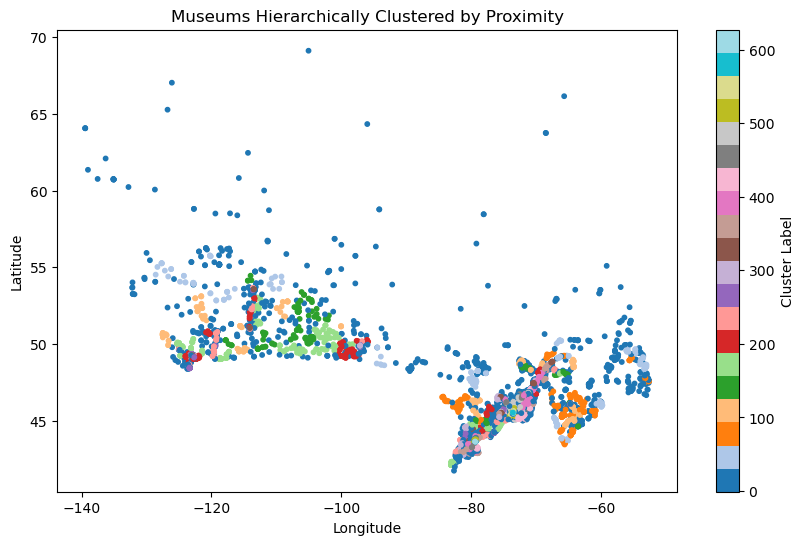

In [56]:
plot_clustered_locations(df, title = 'Museums Hierarchically Clustered by Proximity')

#### Differences Between HDBSCAN and DBSCAN Results

1. More Noise in HDBSCAN?

* At first glance, HDBSCAN has 2041 noise points (-1 cluster), while DBSCAN had only 84.
* However, this doesn’t necessarily mean more points were labeled as noise.
* DBSCAN forces all core points to belong to a cluster, even in areas where density gradually decreases.
* HDBSCAN is more flexible and detects variations in density better.

2. Capturing Variations in Density

* DBSCAN assumes a single density threshold for clusters, leading to fewer but more rigid clusters.
* HDBSCAN allows for varying densities, leading to more but smaller clusters.
* This is why HDBSCAN found 629 clusters, whereas DBSCAN had fewer large clusters.

3. Fewer Arbitrary Mergers

* DBSCAN sometimes merges clusters that are close but have different densities.
* HDBSCAN avoids this by creating more distinct clusters.